## Библиотеки

In [37]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, PrecisionRecallDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

True

## Загрузка и анализ датасета

In [38]:
spam = pd.read_csv('spam.zip', encoding='latin-1')
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [39]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


__Непонятные признаки 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'__, без явного заполнения значениями, думаю их можно просто удалить, либо просто сформирую признаки без этих столбцов

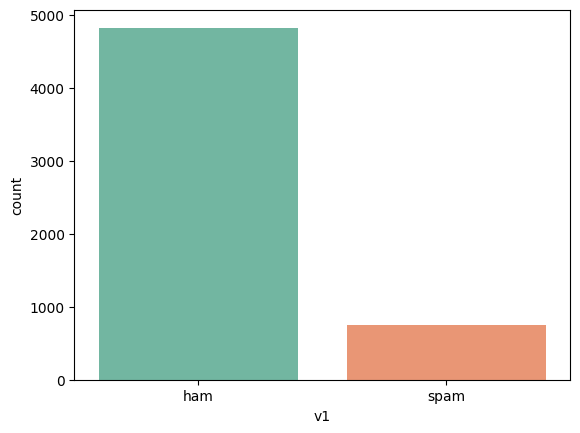

In [40]:
spam.v1.value_counts()
sns.countplot(spam, x = 'v1', palette='Set2')
plt.show()

Несбалансированные признаки, что и так было логично

Дальше просто буду использовать StratifiedKFold для стратификации наших данных в тренировочной и тестовой подвыборке

In [41]:
fract = (spam['v1'] == 'spam').sum()/(spam['v1'] == 'ham').sum()
fract

np.float64(0.15481865284974095)

In [42]:
spam.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [43]:
print(f"Первые 5 строчек датасета:{spam.head().to_string()}")
print(f"Рандомные 3 строчки: {spam.sample(3).to_string()}")

Первые 5 строчек датасета:     v1                                                                                                                                                           v2 Unnamed: 2 Unnamed: 3 Unnamed: 4
0   ham                                              Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...        NaN        NaN        NaN
1   ham                                                                                                                                Ok lar... Joking wif u oni...        NaN        NaN        NaN
2  spam  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's        NaN        NaN        NaN
3   ham                                                                                                            U dun say so early hor... U c already then say...        NaN       

In [44]:
X = spam['v2']
y = spam['v1']
print(f"размерность X: {X.shape}")
print(f"размерность y: {y.shape}")

размерность X: (5572,)
размерность y: (5572,)


In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, random_state=42)

### __Начнем делать модель__

В моделе все буду фиксировать random_state = 42 для воспроизводимости результатов

__Функция загрузки нашего датасета__

In [46]:
def load_data(filepath):
        df = pd.read_csv(filepath, encoding='latin-1')
        return df

__Функция препроцессинга__

Используем __PorterStemmer__ из-за его быстродействия и хорошей работы с английскими языком

Выделяем английские стоп-слова, чистим текст путем приведения к нижнему регистру и удалению лишних пробелов. Думаю, больше ничего удалять не нужно, так как это будет критично для выявления спам-сообщений

__Токенезируем__ и соответственно прописываем нашу конечную функцию __препроцессинга__

In [47]:
class AdvancedTextPreprocessor:
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        
    def clean_text(self, text):
        if pd.isna(text):
            return ""
        
        text = str(text).lower()
        
        #Удаление лишних пробелов
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_stem(self, text):
        tokens = word_tokenize(text)
        filtered_tokens = [
            self.stemmer.stem(word) 
            for word in tokens 
            if word not in self.stop_words and len(word) > 2
        ]
        return filtered_tokens
        
    def preprocess(self, text):
        cleaned_text = self.clean_text(text)
        if not cleaned_text:
            return ""
        tokens = self.tokenize_and_stem(cleaned_text)
        return ' '.join(tokens)




__Оценивающая функция__

Считаем метрики, __F1-score__, строим confusion matrix.

__F1-score__, так как классы несбалансированные и данная метрика будет здесь самая подходящая

In [48]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label='spam')
    
    print(f"\n--- {model_name} ---")
    print(f"F1-Score (spam): {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['ham', 'spam'], 
                yticklabels=['ham', 'spam'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return f1

__Основная функция__, которая собирает все предыдущие воедино и проводит анализ и выводит нашу лучшую модель

Здесь не эксперементируем с GridSearch, обошелся просто cross_val_score

Используем самые дефолтные эстиматоры с их встроенными параметрами

In [49]:
def main():
    df = load_data('spam.zip')
    df = df.rename(columns={'v1': 'target', 'v2': 'text'})
    df = df[['target', 'text']]

    preprocessor = AdvancedTextPreprocessor()
    df['processed_text'] = df['text'].apply(preprocessor.preprocess)
    
    X = df['processed_text']
    y = df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    vectorizer = TfidfVectorizer(
        max_features=3000, min_df=2, max_df=0.8,
        ngram_range=(1, 3)
    )
    
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Multinomial Naive Bayes': MultinomialNB(),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'SVM': SVC(random_state=42, probability=True)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}
    
    for name, model in models.items():
        cv_f1_scores = cross_val_score(
            model, X_train_vectorized, y_train, cv=cv, scoring='f1', n_jobs=-1
        )
        
        model.fit(X_train_vectorized, y_train)
        f1 = evaluate_model(model, X_test_vectorized, y_test, name)
        
        results[name] = {
            'f1_score': f1,
            'cv_f1_mean': cv_f1_scores.mean(),
            'cv_f1_std': cv_f1_scores.std()
        }
    
    results_df = pd.DataFrame(results).T.sort_values('f1_score', ascending=False)
    
    print("\nСравнение моделей")
    print("=" * 50)
    print(f"{'Модель':<25} {'Test F1':<10}")
    print("-" * 50)
    
    for name in results_df.index:
        row = results_df.loc[name]
        print(f"{name:<25} {row['f1_score']:.4f}")
    
    best_model_name = results_df.index[0]
    best_model = models[best_model_name]
    
    print(f"\nЛучшая моделька: {best_model_name}")
    print(f"F1-Score на тесте: {results_df.iloc[0]['f1_score']:.4f}")
    return results_df, vectorizer, best_model

__Функция предсказывания__ по готовым переменным

In [50]:
def predict_spam(model, vectorizer, preprocessor, message):
    processed_text = preprocessor.preprocess(message)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    probability = model.predict_proba(vectorized_text)[0]
    
    result = {
        'prediction': prediction,
        'spam_probability': probability[1] if model.classes_[1] == 'spam' else probability[0],
        'ham_probability': probability[0] if model.classes_[0] == 'ham' else probability[1]
    }
    
    return result

__Проверочка__

Протестируем нашу модель и поглядим на конкретные примеры


--- Logistic Regression ---
F1-Score (spam): 0.8841
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      0.99      0.98       966
        spam       0.96      0.82      0.88       149

    accuracy                           0.97      1115
   macro avg       0.97      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115



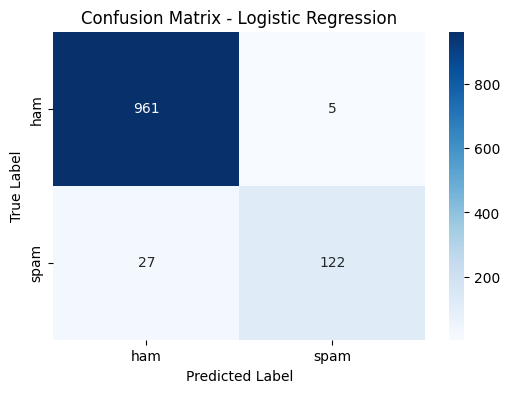


--- Multinomial Naive Bayes ---
F1-Score (spam): 0.8815
Classification Report:
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.98      0.80      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



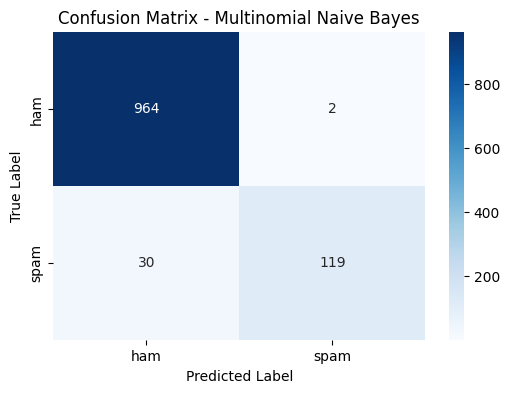


--- Random Forest ---
F1-Score (spam): 0.9124
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



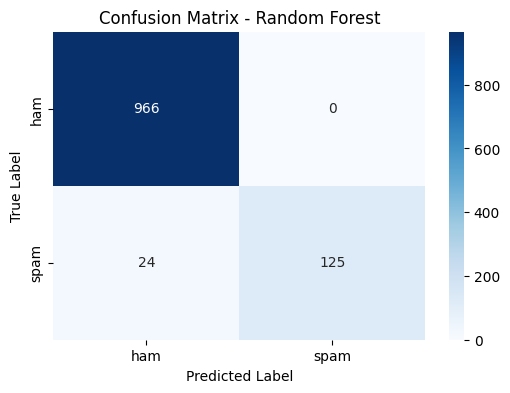


--- SVM ---
F1-Score (spam): 0.9324
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.88      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



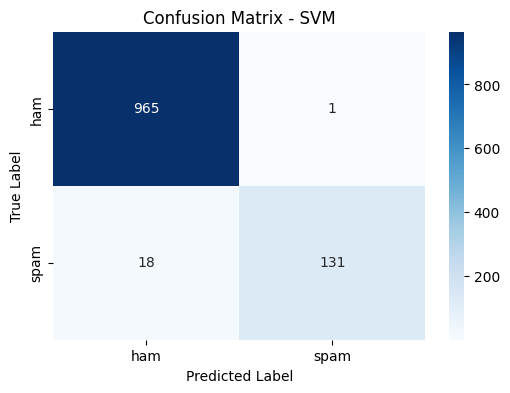


Сравнение моделей
Модель                    Test F1   
--------------------------------------------------
SVM                       0.9324
Random Forest             0.9124
Logistic Regression       0.8841
Multinomial Naive Bayes   0.8815

Лучшая моделька: SVM
F1-Score на тесте: 0.9324

 тест:

 Сообщение: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 8...
Предсказание: spam
Вероятность спама: 1.0000
Вероятность ham: 0.0000

 Сообщение: Hey, are we still meeting for lunch tomorrow?...
Предсказание: ham
Вероятность спама: 0.0007
Вероятность ham: 0.9993

 Сообщение: Congratulations! You've won a $1000 Walmart gift card. Click here to claim your ...
Предсказание: spam
Вероятность спама: 0.9867
Вероятность ham: 0.0133


In [51]:
# Запуск пайплана)
results, vectorizer, best_model = main()

test_messages = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
    "Hey, are we still meeting for lunch tomorrow?",
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize now!"
]
    
print("\n тест:")
print("="*60)
    
preprocessor = AdvancedTextPreprocessor()
for msg in test_messages:
    result = predict_spam(best_model, vectorizer, preprocessor, msg)
    print(f"\n Сообщение: {msg[:80]}...")
    print(f"Предсказание: {result['prediction']}")
    print(f"Вероятность спама: {result['spam_probability']:.4f}")
    print(f"Вероятность ham: {result['ham_probability']:.4f}")

In [52]:
# Простенькие примеры для тестирования
examples = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts",
    "Congratulations! You won $1000 gift card! Click now and give prize!",
    "What time is the meeting today?",
    "URGENT: Your account needs verification immediately"
]

# Предсказание для каждого примера
for msg in examples:
    result = predict_spam(best_model, vectorizer, preprocessor, msg)
    print(f"{msg[:40]}... -> {result['prediction']} (spam: {result['spam_probability']:.3f})")

Free entry in 2 a wkly comp to win FA Cu... -> spam (spam: 0.922)
Congratulations! You won $1000 gift card... -> ham (spam: 0.797)
What time is the meeting today?... -> ham (spam: 0.003)
URGENT: Your account needs verification ... -> ham (spam: 0.215)


In [53]:
best_model

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Поглядим на PR кривую

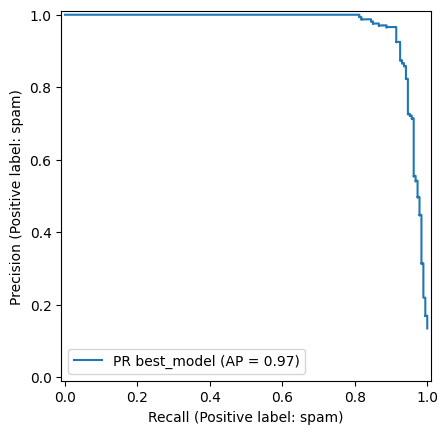

In [54]:
PrecisionRecallDisplay.from_estimator(best_model,vectorizer.transform(X_test),y_test, name = 'PR best_model')
plt.show()